In [1]:
# Standard import(s)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Keras import(s)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D, Conv2DTranspose, Concatenate, Lambda,BatchNormalization, UpSampling2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.backend import set_image_data_format
from keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last

# Preprocessing

In [3]:
# Load in MNIST dataset 
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Get numbers
nb_train   = X_train.shape[0]
nb_test    = X_test .shape[0]
nb_classes = y_train.max() + 1
print(f"Number of training examples: {nb_train}")
print(f"Number of testing  examples: {nb_test}")
print(f"Number of target classes:    {nb_classes}")

# Reshape inputs to (N,N,1), i.e. have one colour dimension
X_train = X_train[..., np.newaxis]
X_test  = X_test [..., np.newaxis]

# Standardise inputs
print("Max. input before scaling: {}".format(X_train.max()))
X_train = X_train / 255.
X_test  = X_test  / 255.

# Get image shape
shape = X_train.shape[1:]
print(f"Image shape:  {shape}")

# Shuffle (dataset is pre-shuffled, but still)
ix_train = np.random.permutation(nb_train)
ix_test  = np.random.permutation(nb_test)

X_train = X_train[ix_train]
y_train = y_train[ix_train]

X_test  = X_test [ix_test]
y_test  = y_test [ix_test]


Number of training examples: 60000
Number of testing  examples: 10000
Number of target classes:    10
Max. input before scaling: 255
Image shape:  (28, 28, 1)


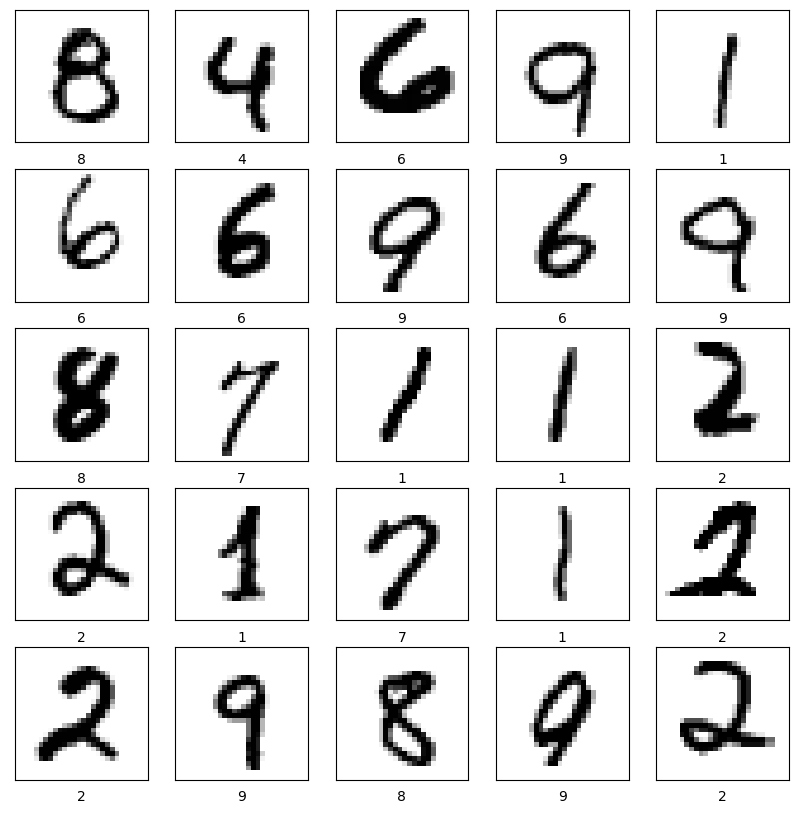

label marks [8 4 6 9 1 6 6 9 6 9 8 7 1 1 2 2 1 7 1 2 2 9 8 9 2]


In [4]:
nb_show = 25
plt.figure(figsize=(10,10))
for i in range(nb_show):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()
print("label marks",y_train[:nb_show])

In [5]:
intermediate_dim =256
latent_dim = 2

# Building encoder

In [6]:
i = Input(shape=shape, name='input')
x = i
x = Conv2D(16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D( 8, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D( 4, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D( 2, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D( 1, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Dense(intermediate_dim, activation='relu')(x)
x = Dense(intermediate_dim, activation='relu')(x)
conv_shape = K.int_shape(x)
e = Flatten()(x)

In [7]:
# Two outputs, for latent mean and log variance (std. dev.)
#Use these to sample random variables in latent space to which inputs are mapped. 
mu = Dense(latent_dim, name='latent_mu')(e)   #Mean values of encoded input
sigma = Dense(latent_dim, name='latent_sigma')(e)  #Std dev. (variance) of encoded input

In [9]:
def sample_z(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps

In [10]:
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu,sigma])

encoder = Model(i, [mu, sigma, z],name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 16)   160         ['input[0][0]']                  
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 8)    1160        ['max_pooling2d[0][0]']          
                                                                                            

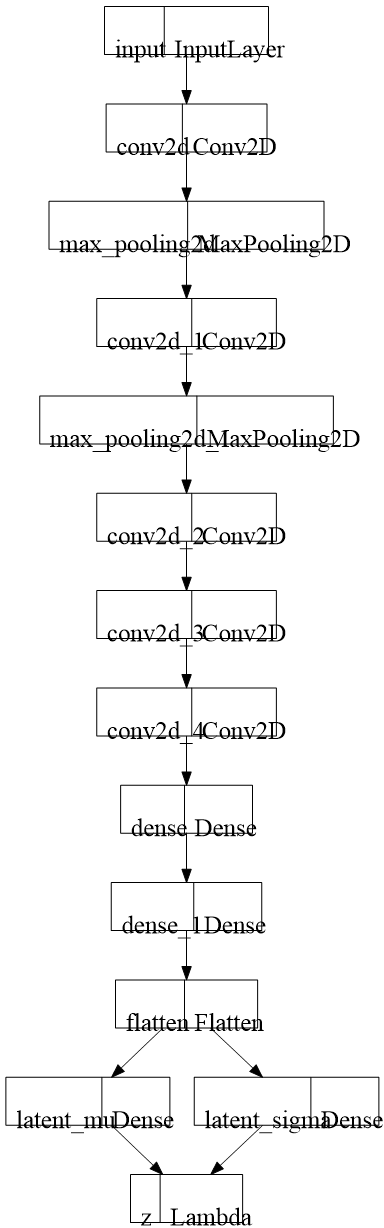

In [53]:
plot_model(encoder)

# Building Decoder

In [12]:
 #Define convolutional decoder model
    
t = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(intermediate_dim, activation='relu')(t)
x = Dense(intermediate_dim, activation='relu')(x)
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(t)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2D(16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(8, kernel_size=(3,3), padding='same', activation='relu')(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(4, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(2, kernel_size=(3,3), padding='same', activation='relu')(x)
o = Conv2D(1, kernel_size=(3,3), padding='same', activation='sigmoid')(x)
decoder = Model(t, o, name='decoder')
decoder.summary()



Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_7 (Dense)             (None, 12544)             37632     
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 16)          36880     
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 8)         1160      
                                                           

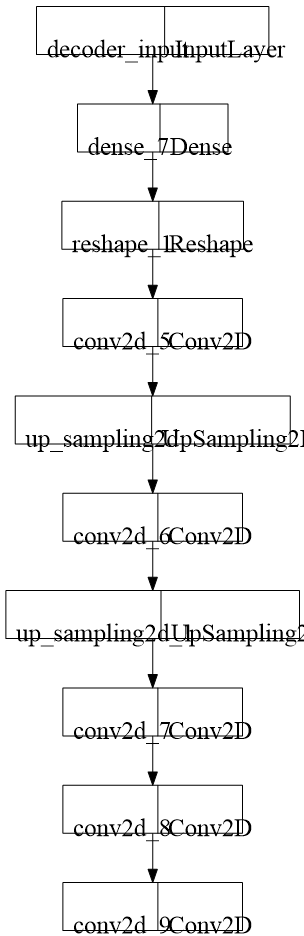

In [55]:
plot_model(decoder)

# Building VAE

In [13]:
## Chain together to get VAE
i = encoder.inputs
if len(i) == 1:
 i = i[0]
 pass
z = encoder(i)[2]
o = decoder(z)

In [14]:
vae=Model(i,o)
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               118189    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         76057     
                                                                 
Total params: 194,246
Trainable params: 194,246
Non-trainable params: 0
_________________________________________________________________


In [15]:
def compile_vae (vae):

    # Get the latent p.d.f. mean and log-variance output layers from VAE encoder
    encoder   = vae.get_layer('encoder')
    z_log_var = encoder.get_layer('latent_sigma').output
    z_mean    = encoder.get_layer('latent_mu').output

    # Define reconstruction loss
    def reco_loss (y_true, y_pred):
        # Use binary cross-entropy loss
        reco_loss_value = binary_crossentropy(y_true, y_pred) # Averages over axis=-1
        reco_loss_value = K.sum(reco_loss_value, axis=(1,2))
        return reco_loss_value

    # Define Kullback-Leibler loss with reference to encoder output layers
    def kl_loss (y_true, y_pred):
        kl_loss_value = 0.5 * (K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var)
        kl_loss_value = K.sum(kl_loss_value, axis=-1)
        return kl_loss_value

    # Define VAE loss
    def vae_loss (y_true, y_pred):
        return reco_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reco_loss, kl_loss])
    return   

In [16]:
compile_vae(vae)

In [17]:
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               118189    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         76057     
                                                                 
Total params: 194,246
Trainable params: 194,246
Non-trainable params: 0
_________________________________________________________________


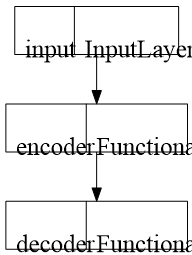

In [52]:
plot_model(vae)

# Traning VAE

In [24]:
# Define parameters
latent_dim =  2
nb_epochs  =  50
batch_size = 128

In [28]:
vae.fit(X_train,X_train,epochs=nb_epochs, batch_size=batch_size,  validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 131s 3ms/sample - loss: 155.1477 - reco_loss: 149.4616 - kl_loss: 5.6861 - val_loss: 155.7397 - val_reco_loss: 150.1677 - val_kl_loss: 5.5721
Epoch 2/50
48000/48000 [==============================] - 130s 3ms/sample - loss: 154.7524 - reco_loss: 149.0224 - kl_loss: 5.7300 - val_loss: 154.7606 - val_reco_loss: 149.1344 - val_kl_loss: 5.6262
Epoch 3/50
48000/48000 [==============================] - 130s 3ms/sample - loss: 154.3074 - reco_loss: 148.5497 - kl_loss: 5.7576 - val_loss: 155.0536 - val_reco_loss: 149.0984 - val_kl_loss: 5.9552
Epoch 4/50
48000/48000 [==============================] - 129s 3ms/sample - loss: 154.1237 - reco_loss: 148.3377 - kl_loss: 5.7859 - val_loss: 154.1272 - val_reco_loss: 148.0215 - val_kl_loss: 6.1058
Epoch 5/50
48000/48000 [==============================] - 129s 3ms/sample - loss: 153.7387 - reco_loss: 147.9433 - kl_loss: 5.7954 - val_loss: 154.064

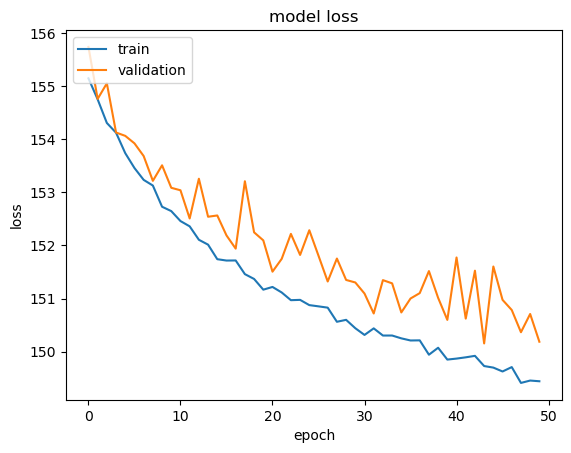

In [47]:
#vae.history.history
# "Loss"
plt.plot(vae.history.history['loss'])
plt.plot(vae.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Visualizing Results

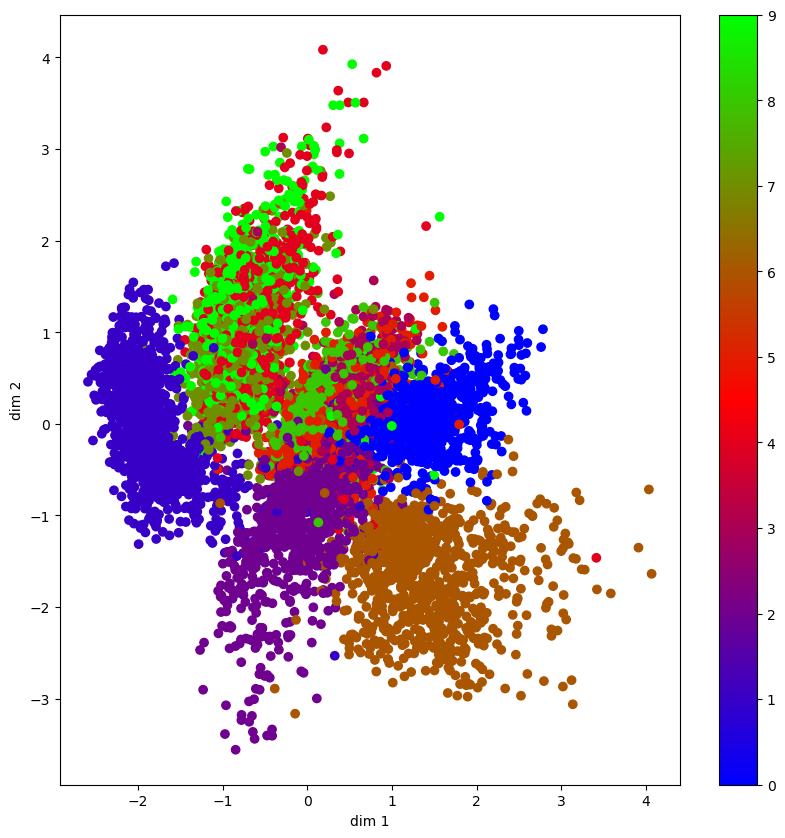

In [29]:
# Visualize results
# =================
#Visualize inputs mapped to the Latent space
#Remember that we have encoded inputs to latent space dimension = 2. 
#Extract z_mu --> first parameter in the result of encoder prediction representing mean

mu, _, _ = encoder.predict(X_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

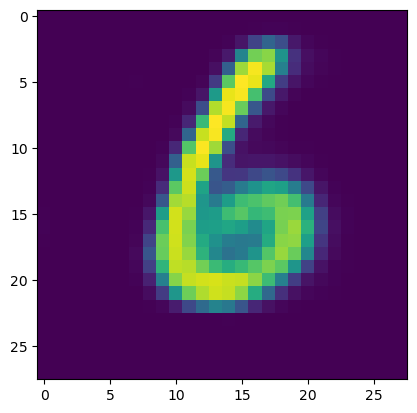

In [56]:
# Visualize images
#Single decoded image with random input latent vector (of size 1x2)
#Latent space range is about -5 to 5 so pick random values within this range
#Try starting with -1, 1 and slowly go up to -1.5,1.5 and see how it morphs from 
#one image to the other.
sample_vector = np.array([[1,-2]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(28,28)
plt.imshow(decoded_example_reshaped)

In [22]:
img_width=28
img_height=28
num_channels=1

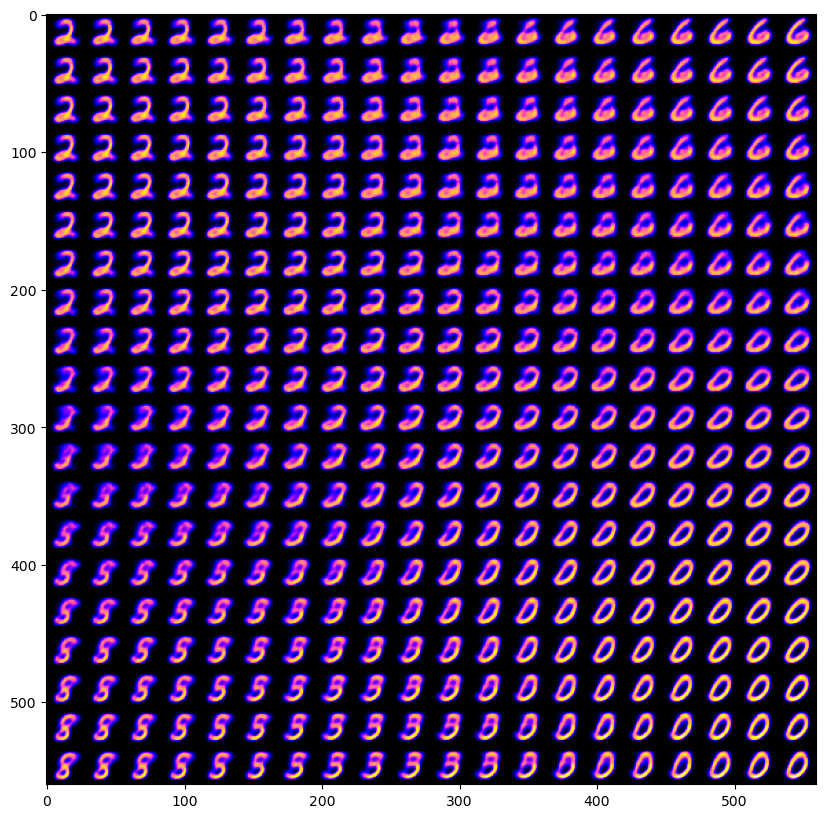

In [49]:
#Let us automate this process by generating multiple images and plotting
#Use decoder to generate images by tweaking latent variables from the latent space
#Create a grid of defined size with zeros. 
#Take sample from some defined linear space. In this example range [-4, 4]
#Feed it to the decoder and update zeros in the figure with output.


n = 20  # generate 15x15 digits
figure = np.zeros((img_width * n, img_height * n, num_channels))

#Create a Grid of latent variables, to be provided as inputs to decoder.predict
grid_x = np.linspace(0, 1, n)
grid_y = np.linspace(0, -1, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        figure[i * img_width: (i + 1) * img_width,
               j * img_height: (j + 1) * img_height] = digit

plt.figure(figsize=(10, 10))
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show() 

# Generative adversary networks

In [57]:
# all imports needed from here
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot

In [58]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [68]:
# create the discriminator
d_model = define_discriminator()
d_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten_2 (Flatten)         (None, 3136)             

In [60]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

In [69]:
# size of the latent space
latent_dim = 100
# create the generator
g_model = define_generator(latent_dim)
g_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 6272)              633472    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                            

In [62]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [70]:
# create the gan
gan_model = define_gan(g_model, d_model)
gan_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 40705     
                                                                 
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


# 7. Discuss components of generative adverserial NN

The components of a generative adversarial network (GAN) consist of two main parts: the generator and the discriminator.

The discriminator is a neural network that is trained to differentiate between real and generated data. The purpose of the discriminator is to act as a "critic" that evaluates the authenticity of the generated samples. It is typically defined using the Sequential function in Keras and is composed of a series of layers such as dense and convolutional layers. The LeakyReLU and Dropout layers are used to introduce non-linearity and reduce overfitting respectively. The loss function used for the discriminator is binary crossentropy, which measures the dissimilarity between the predicted and actual labels (real or fake).

The generator is another neural network that is trained to generate new samples that are similar to the real data. The generator takes a random noise as input and transforms it into a sample that should fool the discriminator into thinking it is real. The Conv2DTranspose layer is used for upsampling the input and increasing the spatial resolution of the generated samples. The sigmoid activation function is used to ensure that the output of the generator is within the range of 0 and 1.

The GAN model is defined as a combination of both the generator and the discriminator, where the generator's output is fed as input to the discriminator. The order of the sequence is such that the generator produces samples that are then evaluated by the discriminator. In the training loop, the generator is updated to produce samples that fool the discriminator while the discriminator is trained to correctly identify the generated samples as fake. The discriminator is not trainable in the GAN model because its weights are not updated during the training process, only the generator's weights are updated.





In [71]:
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y

In [72]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# 8. Discuss the training datasets

The real MNIST dataset is a dataset of handwritten digits that is commonly used for training image classification models. In this case, the load_real_samples function is used to load the MNIST dataset and prepare it for use in the GAN. The data is expanded to 3 dimensions, converted to float32 type, and scaled to have values between 0 and 1.

The generate_real_samples function is used to select a subset of the real data for use in training the discriminator. The function takes as input the dataset and the number of samples to be selected, and uses the randint function to randomly select the indices of the images to be used. The selected images are then returned along with an array of ones, which are the labels for the real images. The y = ones((n_samples, 1)) variable is used to indicate that the images are real and not generated.

The generate_latent_points function is used to generate random points in the latent space, which is the input space of the generator. The function takes as input the dimension of the latent space and the number of points to be generated, and uses the randn function to generate random numbers. The generated points are then reshaped into a batch that can be used as input to the generator.

The generate_fake_samples function is used to create fake samples using the generator. The function takes as input the generator model, the dimension of the latent space, and the number of samples to be generated. The function uses the generate_latent_points function to generate random points in the latent space, which are then used as input to the generator. The generator produces fake samples, which are then returned along with an array of zeros, which are the labels for the fake images. The generated images can be a single random image or multiple images depending on the number of samples passed to the function.






In [73]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
# evaluate the discriminator, plot generated images, save generator model

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename) 

In [74]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 2 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

# 9 Training the GANs

The j loop in the train function is used to iterate over the batches of data in the dataset. The function generates real and fake samples, and trains the discriminator and generator models iteratively. For each iteration of the loop, the function generates a random subset of real samples from the dataset, and uses the generator to produce corresponding fake samples. Then it trains the discriminator model on a mix of real and fake samples. After that, the function generates new random points in the latent space and uses the generator to produce new fake samples from them. These fake samples are used to update the generator model via the discriminator's error. The losses for the generator and discriminator are printed out after each batch.

In [76]:
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim,n_epochs=1)

C:\Users\balay\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


>1, 1/234, d=0.713, g=0.684
>1, 2/234, d=0.700, g=0.699
>1, 3/234, d=0.698, g=0.723
>1, 4/234, d=0.687, g=0.743
>1, 5/234, d=0.679, g=0.759
>1, 6/234, d=0.671, g=0.777
>1, 7/234, d=0.665, g=0.792
>1, 8/234, d=0.660, g=0.802
>1, 9/234, d=0.652, g=0.819
>1, 10/234, d=0.653, g=0.833
>1, 11/234, d=0.646, g=0.825
>1, 12/234, d=0.650, g=0.819
>1, 13/234, d=0.651, g=0.796
>1, 14/234, d=0.656, g=0.770
>1, 15/234, d=0.662, g=0.749
>1, 16/234, d=0.663, g=0.733
>1, 17/234, d=0.662, g=0.721
>1, 18/234, d=0.665, g=0.710
>1, 19/234, d=0.654, g=0.705
>1, 20/234, d=0.653, g=0.702
>1, 21/234, d=0.644, g=0.699
>1, 22/234, d=0.637, g=0.698
>1, 23/234, d=0.630, g=0.698
>1, 24/234, d=0.620, g=0.697
>1, 25/234, d=0.616, g=0.697
>1, 26/234, d=0.610, g=0.698
>1, 27/234, d=0.603, g=0.698
>1, 28/234, d=0.590, g=0.699
>1, 29/234, d=0.578, g=0.700
>1, 30/234, d=0.572, g=0.700
>1, 31/234, d=0.565, g=0.702
>1, 32/234, d=0.552, g=0.703
>1, 33/234, d=0.543, g=0.703
>1, 34/234, d=0.529, g=0.705
>1, 35/234, d=0.522, g=

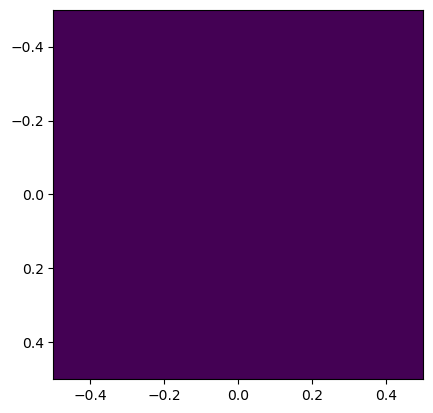

In [79]:
img = generate_fake_samples(gan_model, latent_dim,1)
plt.imshow(img[0])
plt.show()